In [ ]:
# Importamos librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Input
from sklearn.metrics import mean_squared_error
import math
from keras import callbacks
from pathlib import Path 

# En caso de que usemos Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Cargamos el dataset
raw_data = pd.read_csv('/content/drive/MyDrive/Projecto Marvik/Datos/TWTR.csv')
# raw_data = pd.read_csv('/content/drive/MyDrive/Projecto Marvik/Datos/META.csv')
# raw_data = pd.read_csv('/content/drive/MyDrive/Projecto Marvik/Datos/S&P500.csv') # sacado de NASDAQ

Mounted at /content/drive


In [ ]:
# Generamos una funcion para utilizar todo el dataset en el entrenamiento
def run_model(raw_data, lag, lstm_neurons, epochs, optimizer):

  # Nos quedamos solamente con el valor de cierre de la accion
  raw_data = raw_data[['Close']]

  # Normalizamos el dataset
  dataset = raw_data.values
  dataset = dataset.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)

  # Funcion para crear el dataset que le vamos a pasar al modelo, teniendo en cuenta el lag
  def create_dataset(dataset, lag):
      dataX, dataY = np.zeros((len(dataset)-lag,lag)), np.zeros(len(dataset)-lag)
      for i in range(len(dataset)-lag):
          dataX[i,:] = dataset[i:i+lag,0]
          dataY[i] = dataset[i+lag,0]
      return dataX, dataY

  # Ejecutamos la funcion de create_dataset y establecemos el lag
  datasetX, datasetY = create_dataset(dataset, lag)

  # Separamos el dataset en train y test
  train_size = int(len(datasetX))
  
  trainX = datasetX[0:train_size,:]
  trainY = datasetY[0:train_size]

  # Agregamos una dimensión para poder pasarle luego al modelo
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

  # Capas y armado del modelo
  model = Sequential([GRU(lstm_neurons, input_shape=(1, trainX.shape[2])),
                      Dense(lstm_neurons/2, activation='relu'),
                      Dense(lstm_neurons/2, activation='relu'),
                      Dense(1)])

  # Seleccion de metricas y entrenamiento del modelo
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics= "MeanSquaredError")
  
  # Recupera los mejores weights que el modelo encontro en todas las corridas
  earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)
  
  model.fit(trainX, trainY, batch_size=1, epochs=epochs, verbose=1, validation_split=0.1, callbacks=[earlystopping])

  # Hacemos las predicciones
  trainPredict = model.predict(trainX)

  # Invertimos la normalizacion de los datos para poder calcular el RMSE
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([trainY])

  # Usamos el RMSE como métrica para evaluar la eficiencia del modelo
  trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

  # Creamos nuevos datasets para graficar las predicciones
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

  return (trainScore, trainPredictPlot, model, scaler)

In [ ]:
# Luego de optimizar los parametros, entrenamos el modelos con todo el dataset
raw_data = raw_data
lstm_neurons = 64
epochs = 50
best_optimizer = 'Adam'
best_lag = 3

# Corremos la funcion
trainScore, trainPredictPlot, model, scaler = run_model(raw_data, best_lag, lstm_neurons, epochs, best_optimizer)

Epoch 1/50
1023/1023 [==============================] - 10s 4ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 6/50
1023/1023 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
1023

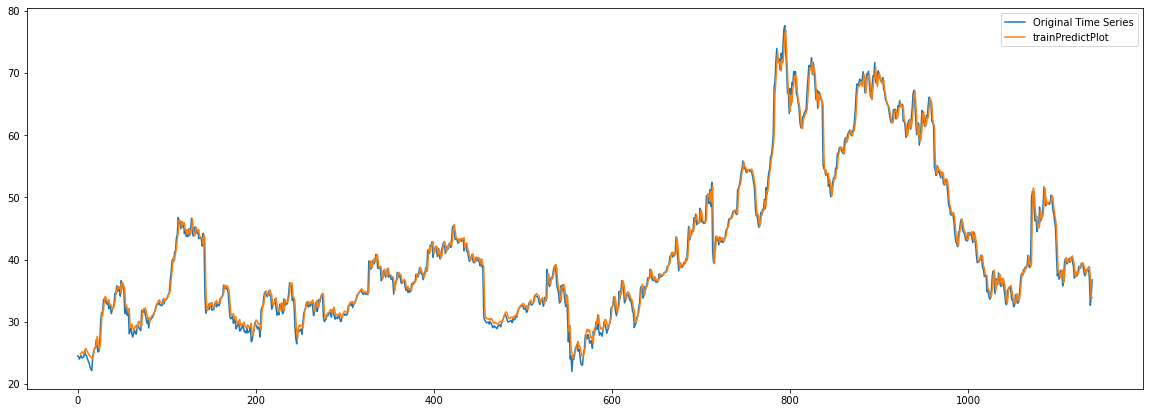

In [ ]:
# Graficamos los resultados del nuevo modelo
plt.figure(figsize=(20,7))
plt.plot(raw_data['Close'])
plt.plot(trainPredictPlot[:])
plt.legend(['Original Time Series','trainPredictPlot'])
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,417
Trainable params: 16,417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def predict_values(days, trainPredict, scaler): 
  future_preds = trainPredictPlot[-best_lag:]

  for i in range(1, days+1):
    preds_scaled = scaler.transform(future_preds[-best_lag:,:])
    pred_val = scaler.inverse_transform(model.predict(preds_scaled.reshape(1,-1,best_lag)))
    future_preds = np.append(future_preds, pred_val, axis=0)

  future_preds = future_preds[best_lag-1:]
  return future_preds

In [ ]:
future_preds = predict_values(10, trainPredictPlot, scaler)

In [ ]:
future_preds_plot = np.empty((len(trainPredictPlot)+len(future_preds), 1))
future_preds_plot[:, :] = np.nan
future_preds_plot[len(trainPredictPlot):, :] = future_preds

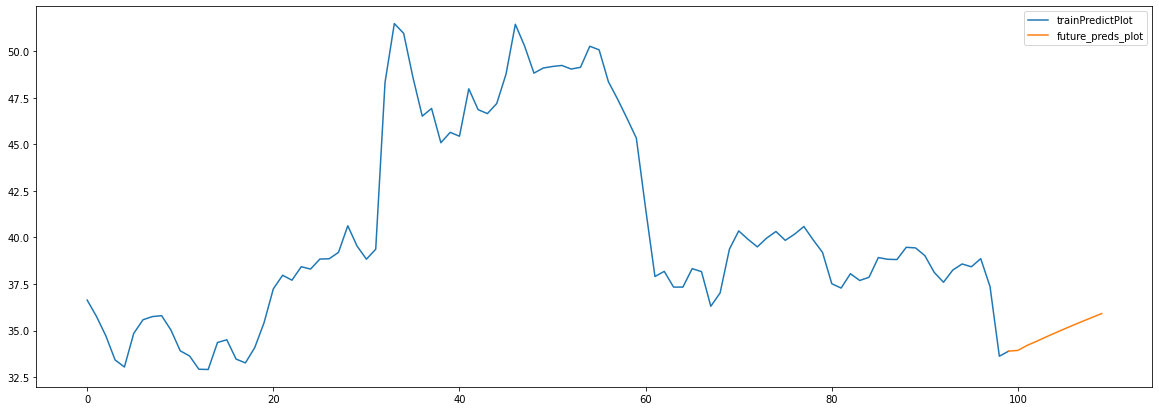

In [ ]:
# Graficamos los ultimos 100 dias del dataset mas la prediccion
plt.figure(figsize=(20,7))
plt.plot(trainPredictPlot[-100:])
plt.plot(future_preds_plot[-100-len(future_preds)+1:])
plt.legend(['trainPredictPlot','future_preds_plot'])
plt.show()